In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from models import cnn
from functions import spectrum, batch

In [48]:
# reimport libraries in case something has changed
import importlib

cnn = importlib.reload(cnn)
spectrum = importlib.reload(spectrum)
batch = importlib.reload(batch)

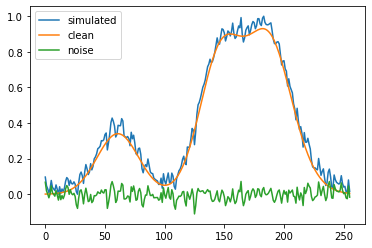

In [49]:
# Generate random noisy data showing the target data
random_data = spectrum.generate_spectrum("gaussian", 256, np.random.randint(0, 10))
plt.plot(random_data.simulated, label="simulated")
plt.plot(random_data.clean, label="clean")
plt.plot(random_data.noise, label="noise")
plt.legend()
plt.show()

In [54]:
# create a sequential model
model = cnn.build_1d_cnn_model(256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 256, 1)           4         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 225, 64)           2112      
                                                                 
 conv1d_1 (Conv1D)           (None, 218, 16)           8208      
                                                                 
 conv1d_2 (Conv1D)           (None, 217, 4)            132       
                                                                 
 dense (Dense)               (None, 217, 3)            15        
                                                        

In [86]:
def func():
    """
    Create a function that outputs synthetic training data and target data
    :return: training (X), target (y)
    :rtype: tuple
    """
    spect = spectrum.generate_spectrum("gaussian", 256, np.random.randint(1, 3))
    return spect.simulated, spect.clean


X, y = batch.generate_batch(func, size=100000)

Epoch 1/250
147/147 [==============================] - 39s 267ms/step - loss: 0.0064 - mean_absolute_error: 0.0282 - mse: 0.0043 - accuracy: 0.0991 - val_loss: 0.0051 - val_mean_absolute_error: 0.0243 - val_mse: 0.0038 - val_accuracy: 0.1698
Epoch 2/250
147/147 [==============================] - 42s 283ms/step - loss: 0.0049 - mean_absolute_error: 0.0258 - mse: 0.0039 - accuracy: 0.0985 - val_loss: 0.0044 - val_mean_absolute_error: 0.0242 - val_mse: 0.0037 - val_accuracy: 0.1719
Epoch 3/250
147/147 [==============================] - 41s 276ms/step - loss: 0.0043 - mean_absolute_error: 0.0256 - mse: 0.0039 - accuracy: 0.0959 - val_loss: 0.0040 - val_mean_absolute_error: 0.0235 - val_mse: 0.0037 - val_accuracy: 0.1786
Epoch 4/250
147/147 [==============================] - 47s 319ms/step - loss: 0.0041 - mean_absolute_error: 0.0253 - mse: 0.0038 - accuracy: 0.0975 - val_loss: 0.0038 - val_mean_absolute_error: 0.0232 - val_mse: 0.0037 - val_accuracy: 0.1789
Epoch 5/250
147/147 [===========

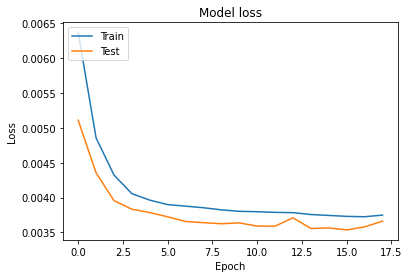

In [87]:
# train
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

callbacks = [
    EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    ModelCheckpoint(filepath='./out/model.{epoch:02d}-{val_loss:.2f}.h5'),
    TensorBoard(log_dir='./logs'),
]
history = model.fit(X, y, epochs=250, verbose=1,
                    validation_split=0.25, batch_size=512, callbacks=callbacks)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

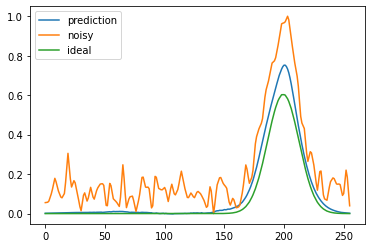

In [185]:
# test
test_data = batch.generate_batch(func, size=1)
test = test_data[0][:, :, 0].T
ideal = test_data[1].T
prediction = model.predict(test_data[0], verbose=False).T
plt.plot(prediction, label="prediction")
plt.plot(test, label="noisy")
plt.plot(ideal, label="ideal")
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model as a tflite model
with open(f'{model_filename}.tflite', 'wb') as f:
    f.write(tflite_model)